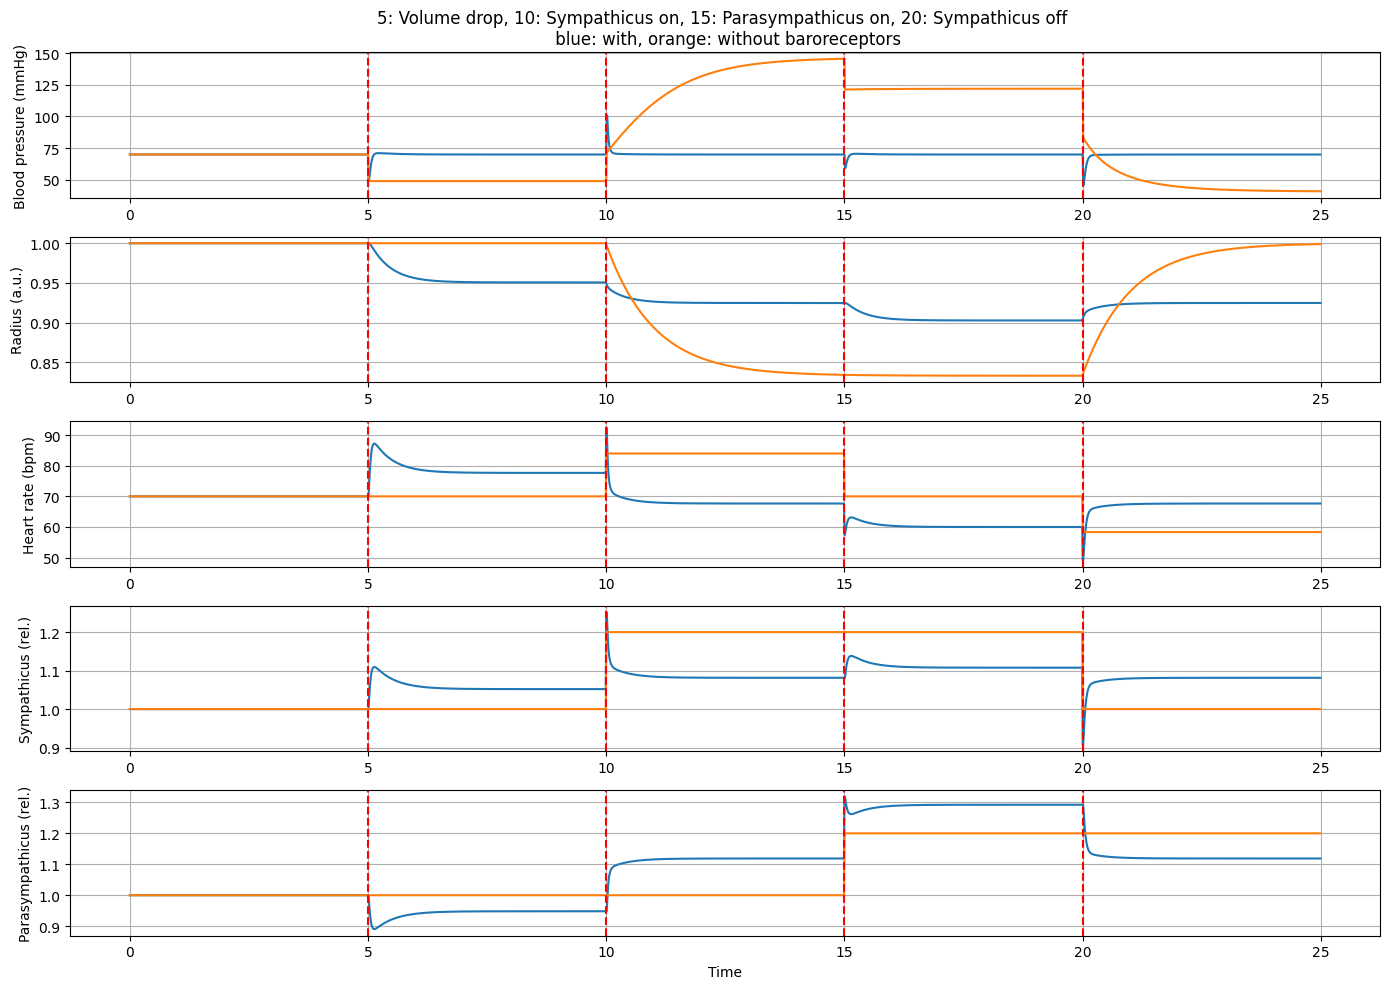

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Simulation settings
# -----------------------------
T = 2500          # number of steps
dt = 0.01         # time step in s
time = np.arange(0, T*dt, dt)

# BP blood pressure
BP_0 = 70

# Heart parameters
HR_0 = 70 / 60   # heart rate in Hz
SV_0 = 0.07      # stroke volume in L
CO_0 = HR_0 * SV_0  # cardiac output L/s

# Vessel parameters
r_0 = 0.001         # vessel radius in m
R_0 = BP_0 / CO_0   # flow resistivity mmHg·s/L
factor = R_0 * (r_0)**4

# Vasoconstriction rate 
k_r = 1

# Baroreflex gain
gain_br = 0.001

# Blood volume
volume_jump_time = 5.0
volume_relative = 0.7

# Sympathicus
symp_act_time = 10.0
symp_deact_time = 20.0

# Parasympathicus
parasymp_act_time = 15.0

# Initial conditions
BP = np.zeros((time.size, 2))
HR = np.zeros((time.size, 2))
SV = np.zeros((time.size, 2))
CO = np.zeros((time.size, 2))
radius = np.zeros((time.size, 2))
R = np.zeros((time.size, 2))
symp = np.zeros((time.size, 2))
parasymp = np.zeros((time.size, 2))

HR[0,0] = HR_0
radius[0,0] = r_0
SV[0,0] = SV_0
BP[0,0] = BP_0
R[0,0] = factor/(r_0)**4
CO[0,0] = HR_0 * SV_0
symp[0,0] = 1
parasymp[0,0] = 1

HR[0,1] = HR_0
radius[0,1] = r_0
SV[0,1] = SV_0
BP[0,1] = BP_0
R[0,1] = factor/(r_0)**4
CO[0,1] = HR_0 * SV_0
symp[0,1] = 1
parasymp[0,1] = 1

# -----------------------------
# Model functions
# -----------------------------

def poiseuille_R(r):
    # Calculate flow resistivity depending on vessel radius
    return factor/r**4

def addsymp(t):
    # Switch sympathicus on and off
    if t == symp_act_time:
        addsymp = 0.2 
    elif t == symp_deact_time:
        addsymp = -0.2
    else:
        addsymp = 0
    return addsymp
    
def addparasymp(t):
    # Switch parasympathicus on
    if t == parasymp_act_time:
        addparasymp = 0.2 
    else:
        addparasymp = 0
    return addparasymp

def stroke_volume(t):
    # Decrease stroke volume suddenly
    SV = SV_0 if t < volume_jump_time else SV_0 * volume_relative
    return SV

# -----------------------------
# Simulation loop
# -----------------------------
for i in range(1, len(time)):
    t = time[i]

    # Calculate BP error
    error = BP[i-1,0] - BP_0 if i>1 else 0.0

    # Positive error decreases sympathicus, increases parasympathicus
    # Negative error increases sympathicus, decreases parasympathicus
    symp[i,0] = symp[i-1,0] + addsymp(t) - gain_br * error 
    parasymp[i,0] = parasymp[i-1,0]  + addparasymp(t) + gain_br * error
    symp[i,1] = symp[i-1,1] + addsymp(t)
    parasymp[i,1] = parasymp[i-1,1] + addparasymp(t)
    
    # Stroke volume (modulated by sympathicus, instantaneous)
    SV[i,0] = stroke_volume(t) * symp[i,0] # inotropy
    SV[i,1] = stroke_volume(t) * symp[i,1] # inotropy
    
    # Heart rate (modulated by sympathicus and parasympathicus, instantaneous)
    HR[i,0] = HR_0 * symp[i,0] / parasymp[i,0] # chronotropy
    HR[i,1] = HR_0 * symp[i,1] / parasymp[i,1] # chronotropy

    # Cardiac output
    CO[i,0] = HR[i,0] * SV[i,0]
    CO[i,1] = HR[i,1] * SV[i,1]
    
    # Vessel radius (modulated by sympathicus, with rate constant k_r)
    radius[i,0] = radius[i-1,0] + k_r * dt * (r_0 /symp[i,0] - radius[i-1,0])
    radius[i,1] = radius[i-1,1] + k_r * dt * (r_0 /symp[i,1] - radius[i-1,1])

    # Flow resistivity (depending on vessel radius)
    R[i,0] = poiseuille_R(radius[i,0])
    R[i,1] = poiseuille_R(radius[i,1])

    # Blood pressure
    BP[i,0] = CO[i,0] * R[i,0]
    BP[i,1] = CO[i,1] * R[i,1]

# -----------------------------
# Plotting
# -----------------------------
plt.figure(figsize=(14,10))

plt.subplot(5,1,1)
plt.plot(time, BP)
plt.axvline(5, color='red', linestyle='--')
plt.axvline(10, color='red', linestyle='--')
plt.axvline(15, color='red', linestyle='--')
plt.axvline(20, color='red', linestyle='--')
plt.title("5: Volume drop, 10: Sympathicus on, 15: Parasympathicus on, 20: Sympathicus off \n blue: with, orange: without baroreceptors")
plt.ylabel("Blood pressure (mmHg)")
plt.grid(True)

plt.subplot(5,1,2)
plt.plot(time, radius*1000)
plt.axvline(5, color='red', linestyle='--')
plt.axvline(10, color='red', linestyle='--')
plt.axvline(15, color='red', linestyle='--')
plt.axvline(20, color='red', linestyle='--')
plt.ylabel("Radius (a.u.)")
plt.grid(True)

plt.subplot(5,1,3)
plt.plot(time, HR*60)
plt.axvline(5, color='red', linestyle='--')
plt.axvline(10, color='red', linestyle='--')
plt.axvline(15, color='red', linestyle='--')
plt.axvline(20, color='red', linestyle='--')
plt.ylabel("Heart rate (bpm)")
plt.grid(True)

plt.subplot(5,1,4)
plt.plot(time, symp)
plt.axvline(5, color='red', linestyle='--')
plt.axvline(10, color='red', linestyle='--')
plt.axvline(15, color='red', linestyle='--')
plt.axvline(20, color='red', linestyle='--')
plt.ylabel("Sympathicus (rel.)")
plt.grid(True)

plt.subplot(5,1,5)
plt.plot(time, parasymp)
plt.axvline(5, color='red', linestyle='--')
plt.axvline(10, color='red', linestyle='--')
plt.axvline(15, color='red', linestyle='--')
plt.axvline(20, color='red', linestyle='--')
plt.ylabel("Parasympathicus (rel.)")
plt.xlabel("Time")
plt.grid(True)

plt.tight_layout()
plt.show()
